### Задание
<ul>
<li>цели и задачи проекта, описание исходных и обработанных данных и признаков.</li>
<li>первичный анализ признаков</li>
<li>первичный визуальный анализ признаков</li>
<li>если пришли к каким-то "инсайтам", обнаружили закономерности – изложите</li>
<li>описание предобработки данных</li>
<li>если создаются признаки, то описание этого процесса</li>
<li>кросс-валидация, построение кривых валидации и обучения</li>
<li>оценка модели с описанием выбранной метрики. Опишите простыми словами качество модели, как она может применяться</li>
<li>выводы: как построенная модель может применяться на практике, какие бизнес-задачи решать. Подведите итог, опишите, что еще можно сделать, а что сделать не удалось.</li>
</ul>
--------------------------------------------------------------------------------------------------------------------------

### 1. Цели и задачи проекта, описание исходных и обработанных данных и признаков.

Имеются последовательности веб-сайтов (с временными метками) для N пользователей, записанные в csv-файлы (один файл - один пользователь). Выборки (папки) есть для 3, 10 и 150 пользователей (есть еще для 3000, но это "на бадущее"). Используя эти данные нужно идентифицировать пользователей (исследовать метрики качества для разных видов классификации: прогноз уникального значения, one-against-all)

In [35]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from glob import glob
import os
import pickle
import itertools
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tqdm
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
PATH_TO_DATA = 'C:\\Users\\Пользователь\\Desktop\\PY_spec\\1_prepare_data\\capstone_user_identification' 
pd.read_csv(os.path.join(PATH_TO_DATA,'10users\\user0031.csv')).head()

,timestamp,site
0,2013-11-15 08:12:07,fpdownload2.macromedia.com
1,2013-11-15 08:12:17,laposte.net
2,2013-11-15 08:12:17,www.laposte.net
3,2013-11-15 08:12:17,www.google.com
4,2013-11-15 08:12:18,www.laposte.net


Следуя заданию первой недели и статье "A Tool for Classification of Sequential Data" предположим, что разбить последовательность сайтов на куски по 10 штук - не самая плохая идея. Также будем использовать мешок слов над сайтами без лемматизации или другой обработки. Обернем все это в неуклюжую функцию - нагромождение перемешанных pandas и numpy команд.<br> Особенно обращаем внимание на безобразие, котрое начинается в 32 строке, т.к. все это работает на винде, которая обращается к файлам сортируя их по имени, прогон на Ubunty на второй неделе превратил все в кашу

In [3]:
def prepare_train_set(path_to_csv_files, session_length=10):
    
    data = pd.DataFrame(columns=['timestamp', 'site', 'id']) #создаем базовый фрейм для наполнения из csv
    for name in glob(path_to_csv_files +'\\*.csv'):          #открываем файлы и заполняем фрейм, юзер = имя файла
        data_1 = pd.read_csv(name, sep=',')
        data_1['id'] = os.path.basename(name)
        data = pd.concat([data, data_1])
    data = data.reset_index(drop=True)                       #raw-фрейм
   
    counter = pd.DataFrame(data.site.value_counts())         #создаем фрейм с часотами и дополнительными id сайтов
    counter = counter.reset_index()
    counter['id'] = counter.index + 1
    counter.set_index('id')
    counter = counter.set_index('index')
    counter = counter.reset_index()
    
    site_freq = {}                                           #переводим фрейм в словарь
    for i in range(counter.shape[0]):
        site_freq[counter.iloc[i,:][0]] = [counter.iloc[i,:][2], counter.iloc[i,:][1]]
    
    data_1 = data.drop(['timestamp'], axis=1)                #затираем отметку времени
    users = list(data_1.id.unique())                         #список юзеров
    for i in range(data_1.shape[0]):                         #кодируем сайты и юзеров
        data_1.iloc[i,0] = site_freq[str(data_1.iloc[i,0])][0]
        data_1.iloc[i,1] = users.index(str(data_1.iloc[i,1])) + 1
    
    data_group = data_1.groupby(by=['id']).count()
    n = 0
    l = list(data_group.index.unique())                       #коды юзеров
    s = session_length
    for i in l:                                               #для каждого юзера
        #data_group = data_1.groupby(by=['id']).count()        #считаем количество сайтов
        if int(data_group.loc[i]) % s != 0:
            matrix = np.array((s - int(data_group.loc[i]) % s)*[0,i]).reshape(((s - int(data_group.loc[i]) % s),2)) #строим матрицу "нехватки до полной сессии"
            df_insert = pd.DataFrame(matrix, columns = ['site', 'id']) 
            dfA = data_1.iloc[:int(data_group.loc[i])+n, ]        #делим фрейм и вставляем нули
            dfB = data_1.iloc[int(data_group.loc[i])+n:, ]
            data_1 = dfA.append(df_insert).append(dfB).reset_index(drop = True)
        n += int(data_1.groupby(by=['id']).count().loc[i])    #обновляем счетчик позиции для вставки
    
    
    data_2 = pd.DataFrame(data_1.site.values.reshape((data_1.shape[0] // s,s))#, создаем фрейм, пока убираем имена колонок
                      #columns=['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8', 'site9', 'site10']
                     )
    data_2['user_id'] = list(data_1.id[::s, ])
    
    return data_2, site_freq

In [4]:
train_data_toy, site_freq_3users = prepare_train_set(os.path.join(PATH_TO_DATA, '3users'), 
                                                     session_length=10)
train_data_toy

,0,1,2,3,4,5,6,7,8,9,user_id
0,3,2,2,8,2,1,10,5,11,9,1
1,3,1,1,1,0,0,0,0,0,0,1
2,3,2,6,6,2,0,0,0,0,0,2
3,4,1,2,1,2,1,1,5,7,4,3
4,4,1,2,0,0,0,0,0,0,0,3


In [5]:
site_freq_3users

{'google.com': [1, 9],
 'oracle.com': [2, 8],
 'vk.com': [3, 3],
 'meduza.io': [4, 3],
 'mail.google.com': [5, 2],
 'football.kulichki.ru': [6, 2],
 'yandex.ru': [7, 1],
 'geo.mozilla.org': [8, 1],
 'plus.google.com': [9, 1],
 'accounts.google.com': [10, 1],
 'apis.google.com': [11, 1]}

Ну хоть словарь сайтов формируется как следует. Делает это долго, но так как мы его запишем "и тааак сойдет". Вообще ускорить его формирование очень интересно (займемся факультативно)<br> Начнем заниматься разреженной матрицей, зададим ее руками

In [6]:
def csr(X_toy):
    indptr = [0]
    indices = []
    data = []
    vocabulary = dict(zip(np.unique(X_toy)[1:], np.unique(X_toy)[1:]))
    for session in X_toy:
        for site in session:
            if site != 0:
                index = vocabulary.setdefault(site, len(vocabulary))
                indices.append(index)
                data.append(1)
        indptr.append(len(indices))

    return csr_matrix((data, indices, indptr), shape=(X_toy.shape[0],len(vocabulary)))

Посмотрим как у нас дела

In [7]:
%%time
train_data_150users, site_freq_150users = prepare_train_set(os.path.join(PATH_TO_DATA, '150users'),
                                                            session_length=10)

Wall time: 5min 30s


In [8]:
%%time
X_150users, y_150users = train_data_150users.iloc[:, :-1].values, \
                         train_data_150users.iloc[:, -1].values
X_sparse_150users = csr(X_150users)

Wall time: 3.13 s


In [9]:
%%time
clf = LogisticRegression(n_jobs=-1)
cross_val_score(clf, X_sparse_150users, y_150users).mean()

Wall time: 10min


0.31041677518450406

<b>Вывод:</b> в целом все, вроде, понятно - на основе базовых признаков (время и сайты) можно строить дополнительные: длина сессии, н-граммы, частотные показатели (например, доля "популярных" сайтов в сессии), рассмотрим структуру признаков

### 2. Первичный анализ признаков, предобработка, визуальный анализ, предобработка, создание признаков

Подкорректируем функцию, чтобы все не "улетало" на Ubunty-машине и фрейм строился с показателями времени, уникальных сайтов и т.д. Все по прежнему Долго - го изучать чужие функции

In [4]:
def prepare_train_set_with_fe(path_to_csv_files, 
                              site_freq_path, 
                              feature_names,
                              session_length=10, 
                              window_size=10):

    data = pd.DataFrame(columns=['timestamp', 'site', 'id'])                # созжаем фрейм для заполнения 
    for name in glob(path_to_csv_files+'\\*.csv'):                          # перебираем все файлы
        data_1 = pd.read_csv(name, sep=',')                                 # каждый файл переводим во фрейм 
        data_1['id'] = int(''.join([i for i in os.path.basename(name) if i.isdigit()]))   # проставляем колонку id номером в названии файла
        data = pd.concat([data, data_1])                                    # присоединяем к исходному фрейму

    data = data.reset_index(drop=True)                                      # индекс по новой 
    data['timestamp'] = pd.to_datetime(data['timestamp'])                   # заполняем время

    with open(site_freq_path, 'rb') as site_freq_pkl:                       # подгружаем словарь сайтов
        site_freq = pickle.load(site_freq_pkl)

    data_1 = data.copy(deep=True)                                           # копируем, чтобы можно было перенести данные о времени на каждом сайте обращаясь параллельно к двум фреймам
    #users = list(data.id.unique())

    for i in range(data.shape[0]):                                          # по всем активностям во фрейме
        if i < data.shape[0] - 1 and data.iloc[i,2] == data.iloc[i+1,2]:    # пока внутри фрейма и пользователь следующей записи тот же, что и в текущей записи
            data_1.iloc[i,0] = int((data.iloc[i+1,0] - data.iloc[i,0]).total_seconds()) # замени отметку времени на разность в секундах
        else: data_1.iloc[i,0] = 0                                          # или поставь 0
        data_1.iloc[i,1] = site_freq[str(data.iloc[i,1])][0]                # сайты замени их номерами в частотном словаре 

    data_1['hour'] = data['timestamp'].apply(lambda x: x.hour)              # время переведи в часы
    data_1['day'] = data['timestamp'].apply(lambda x: x.dayofweek)          # время переведи в день недели

    data_group = data_1[['site', 'id']].groupby(by=['id']).count()          # сколько записей на каждого пользователя

    N=session_length
    data_11 = np.asarray(data_1)                                            # нампаим в надежде на ускорение...зря                                           

    gf = np.matrix([0,0,0,0,0])                                             # вспомогательная матрица с количеством столбцов по количеству учитываемых данных по каджой записи 
    l = list(data_group.index.unique())                                     # индексы пользователей
    for i in l:                                                             # для каждого пользователя
        quantity = int(data_group.loc[i])                                   # количество записей
        if quantity % N != 0:                                               # если не делится на длину сессии
            matrix = np.array((N - quantity % N)*[0,0,i,0,0]).reshape(((N - quantity % N),5)) # докинем нулей с идентификатором пользователя
            gf = np.concatenate((gf, data_11[data_11[:,2] == i], matrix))   # присоединим к матрице
        else:
            gf = np.concatenate((gf, data_11[data_11[:,2] == i]))           # аналогично, но без нулевой матрицы
    data_11 = np.delete(gf, [0], axis=0)                                    # удалим первую строку нулей

    data_time = data_11[:,0].reshape((data_11.shape[0] // N), N)            # решейп столбцов матрицы
    data_site = data_11[:,1].reshape((data_11.shape[0] // N), N)

    session_timing = pd.DataFrame(np.concatenate((data_site,                # объединяем матрицу и переводим ее в df   
                                                  data_time,
                                                  data_11[::N,2],
                                                  data_11[::N,3],
                                                  data_11[::N,4],
                                                  data_11[::N,2]),
                                                 axis=1))

    session_timing.iloc[:,19] = session_timing.iloc[:, 10:19].sum(axis=1).astype(int) # считаем продолжительность сессии
    session_timing.iloc[:,20] = session_timing.iloc[:, 0:10].apply(lambda x: len(set(filter(lambda a: a != 0, x))), axis=1) # уникальные сайты

    session_timing.columns = feature_names
    
    return session_timing

сформируем фреймы по 10 и 150 ползователям и посмотрим на распределение данных

In [11]:
%%time

feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'target']

train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'), 
                                               site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                               feature_names=feature_names, 
                                               session_length=10)

train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users'), 
                                                site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                                                feature_names=feature_names, 
                                                session_length=10)


Wall time: 8min 37s


In [12]:
train_data_10users

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,574,134,3,134,134,3,134,204,134,...,20,1,0,1,0,33,5,8,4,31
1,420,193,697,254,134,31,400,3338,219,55,...,0,1,3,3,8,284,10,8,4,31
2,55,3,55,55,5,295,420,333,897,55,...,0,0,1,0,0,258,7,8,4,31
3,476,4379,476,55,55,55,55,981,199,124,...,25,1,0,0,0,30,6,8,4,31
4,343,55,5,4515,259,211,4398,2139,684,2139,...,1,0,1,1,0,6,9,8,4,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14056,3,4,6,10,2,21,3,6,27,65,...,0,1,23,1,0,27,8,15,2,241
14057,10,21,65,27,30,3,4,9,4,30,...,0,0,2,1,6,11,8,15,2,241
14058,33,4,9,6,10,51,9,33,4,4,...,1,0,0,5,8,16,6,15,2,241
14059,4,4,4,43,51,4,3,3,9,4,...,1,12,1,1,0,242,5,15,2,241


In [13]:
#распределение целевой переменной
train_data_10users.target.value_counts()

128    2796
39     2204
207    1868
127    1712
237    1643
33     1022
50      802
31      760
100     720
241     534
Name: target, dtype: int64

<AxesSubplot:>

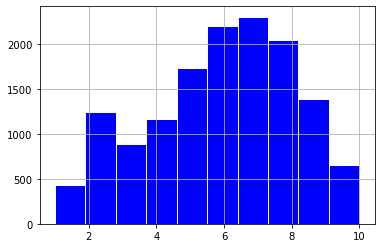

In [14]:
#уникальность в сессии
train_data_10users['#unique_sites'].hist(color='b', edgecolor='w')

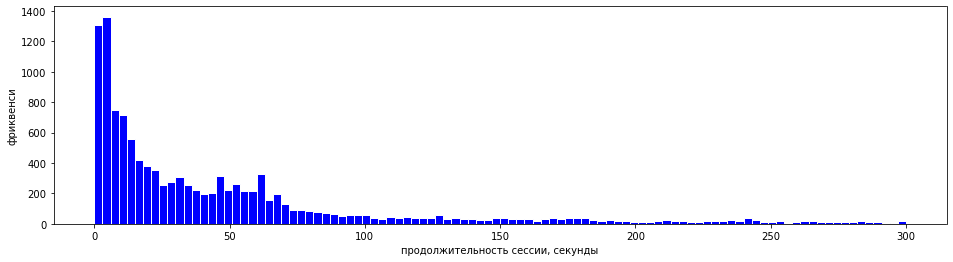

In [15]:
train_data_10users[train_data_10users.session_timespan <= 300].session_timespan.plot.hist(
    color='b', edgecolor='w', bins=100, figsize=(16, 4))
plt.xlabel('продолжительность сессии, секунды')
plt.ylabel('фриквенси')
plt.show()

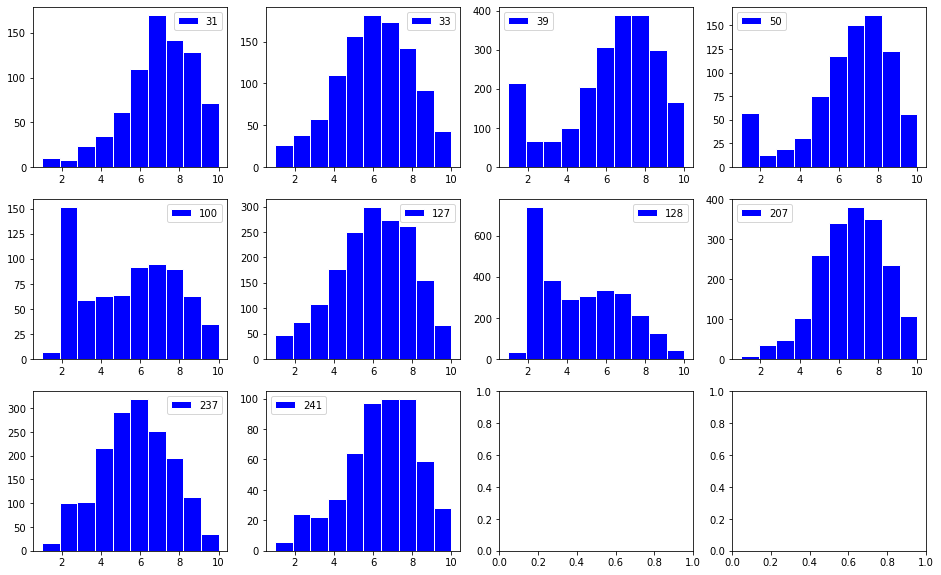

In [16]:
# списано во время peer-3w)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
row, column = 0, 0

for idx, (user, sub_df) in  enumerate(train_data_10users.groupby(['target'])): 
    axes[row, column].hist(sub_df['#unique_sites'], color='b', edgecolor='w')
    axes[row, column].legend([user])
    
    column += 1
    if column == 4:
        column = 0
        row += 1

В общем показатели уникальности видятся не самыми перспективными, но попробуем создать фич:
<ol>
<li>насколько сессия состоит из популярных сайтов(x/10),</li> 
<li>сколько популярных сайтов представлено в сессии</li>
все для "10&10"

In [17]:
def feature_engineering(path_to_csv_files,                                # считаем базовую функцию только над сайтами
                        site_freq_path, 
                        number_of_pop_sites):
    
    data = pd.DataFrame(columns=['site', 'id'])
    for name in glob(path_to_csv_files+'\\*.csv'):
        data_1 = pd.read_csv(name, sep=',')
        data_1 = data_1.drop(['timestamp'], axis = 1)
        data_1['id'] = int(''.join([i for i in os.path.basename(name) if i.isdigit()]))   
        data = pd.concat([data, data_1])

    data = data.reset_index(drop=True)

    with open(site_freq_path, 'rb') as site_freq_pkl:
        site_freq = pickle.load(site_freq_pkl)

    data_1 = data.copy(deep=True)
    users = list(data.id.unique())

    for i in range(data.shape[0]):
        data_1.iloc[i,0] = site_freq[str(data.iloc[i,0])][0]

    data_group = data_1[['site', 'id']].groupby(by=['id']).count()

    N=10
    data_11 = np.asarray(data_1)

    gf = np.matrix([0,0])                                            

    l = list(data_group.index.unique())
    for i in l:    
        quantity = int(data_group.loc[i])
        if quantity % N != 0:
            matrix = np.array((N - quantity % N)*[0,i]).reshape(((N - quantity % N),2))
            gf = np.concatenate((gf, data_11[data_11[:,1] == i], matrix))
        else:
            gf = np.concatenate((gf, data_11[data_11[:,1] == i]))
    data_11 = np.delete(gf, [0], axis=0)  

    session = pd.DataFrame(np.concatenate((data_11[:,0].reshape((data_11.shape[0] // N), N), data_11[::N,1]), axis=1))

    def count_lists(popular, session):                                # функция считает взаимные вхождения двух списков 
        counter_session_only_pop = 0
        counter_session_number_of_pop = 0
        for i in popular:
            counter_session_only_pop += session.count(i)
        for i in set(session):
            counter_session_number_of_pop += popular.count(i)    
        return counter_session_only_pop, counter_session_number_of_pop

    top5_freqs = [i[0] for i in list(site_freq.values())[:number_of_pop_sites]] #сколько сайтов считаем "популярными"

    session['part_pop'] = 0
    session['k_pop'] = 0

    session.iloc[:,11] = session.iloc[:, 0:10].apply(lambda x: count_lists(top5_freqs, list(x))[0], axis=1)
    session.iloc[:,12] = session.iloc[:, 0:10].apply(lambda x: count_lists(top5_freqs, list(x))[1], axis=1)

    return session.iloc[:,11:13]

In [18]:
new_features_10users = feature_engineering (os.path.join(PATH_TO_DATA,'10users'),
                                            os.path.join(PATH_TO_DATA,'site_freq_10users.pkl'), 
                                            number_of_pop_sites=10)

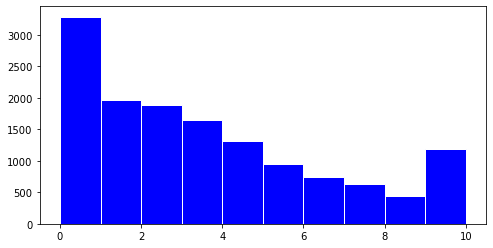

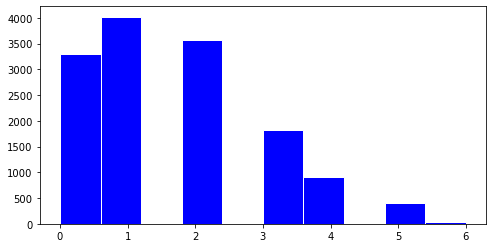

In [19]:
plt.figure(figsize = (8, 4))
plt.hist(new_features_10users.part_pop, color='b', edgecolor='w')
plt.show()
plt.figure(figsize = (8, 4))
plt.hist(new_features_10users.k_pop, color='b', edgecolor='w')
plt.show()

*1. насколько сессия состоит из популярных сайтов(x/10)<br/>*
при поп-группе размером в 10 сайтов на 10 пользователях - более 3000 сессий на "особых" сайтах, что потенциально неплохо для последующей идентификации

*2. сколько популярных сайтов представлено в сессии<br/>*
много пользователей с 1-2 сайтами, посмотрим, что получится<br/>

Любопытно, продолжим - что там с линейными алгоритмами

In [5]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

#стратифицированное разбиение по 3 фолдам
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

In [21]:
%%time
logit_c_values = np.linspace(0.1, 7, 20)

logit_grid_searcher = LogisticRegressionCV(logit_c_values, cv = skf, multi_class='multinomial', n_jobs=2, random_state=17) 
logit_grid_searcher.fit(X_sparse_10users.todense(), y_10users)

Wall time: 5min 48s


LogisticRegressionCV(Cs=array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ]),
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='multinomial', n_jobs=2, random_state=17)

0.7774695967569873 1.9157894736842107


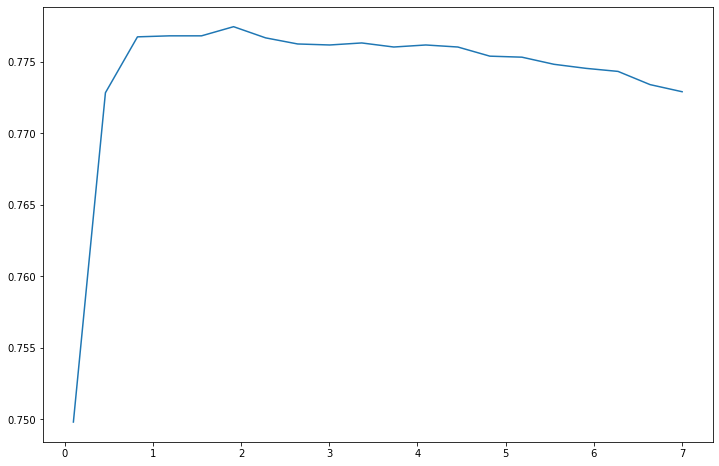

In [22]:
logit_mean_cv_scores = logit_grid_searcher.scores_[1].mean(axis=0)
print(max(logit_mean_cv_scores), logit_grid_searcher.Cs_[np.argmax(logit_mean_cv_scores)])
plt.figure(figsize = (12, 8))
plt.plot(logit_c_values, logit_mean_cv_scores);

In [6]:
%%time
svm_params = {'C': np.linspace(1e-3, 1, 30)}

svm = LinearSVC(random_state=17)
svm_grid_searcher = GridSearchCV(svm, svm_params) 
svm_grid_searcher.fit(X_sparse_10users, y_10users)

Wall time: 2min 58s


GridSearchCV(estimator=LinearSVC(random_state=17),
             param_grid={'C': array([0.001     , 0.03544828, 0.06989655, 0.10434483, 0.1387931 ,
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])})

0.6121958403854488 0.035448275862068966


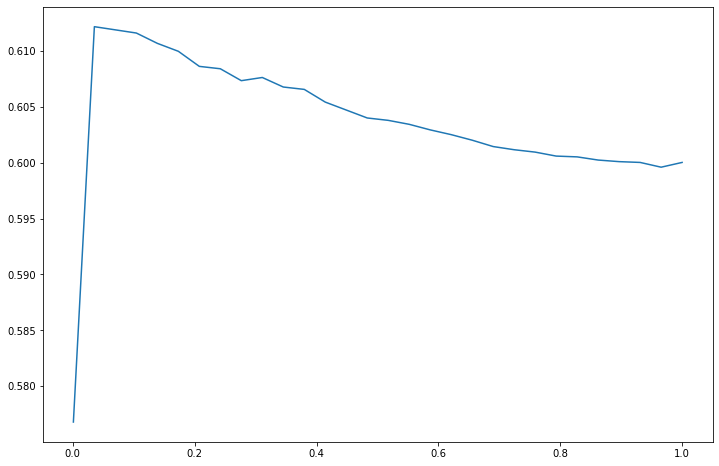

In [7]:
plt.figure(figsize = (12, 8))
print(svm_grid_searcher.best_score_, svm_grid_searcher.best_params_['C'])
plt.plot(svm_params['C'], svm_grid_searcher.cv_results_['mean_test_score']);

Без разделения на трейн/валид aka week_4 логит отработал лучше, посмоторим.<br/>Заведем функцию и посмотрим, сколько времени это займет на ноуте

<img src="https://mem-baza.ru/_ph/1/2/907722612.jpg?1600932156"/>

In [8]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):

    with open(path_to_X_pickle, 'rb') as X_sparse_pkl:
        X_sparse = pickle.load(X_sparse_pkl)
    with open(path_to_y_pickle, 'rb') as y_pkl:
        y = pickle.load(y_pkl)
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y,
                                                          test_size=test_size,
                                                          random_state=random_state, 
                                                          stratify=y)
    
    CV_accuracy = cross_val_score(estimator, X_train, y_train, cv=cv).mean()
    accuracy = accuracy_score(y_valid, estimator.fit(X_train, y_train).predict(X_valid))
    
    return CV_accuracy, accuracy

In [12]:
PATH_TO_DATA_2 = 'C:\\Users\\Пользователь\\Desktop\\PY_spec\\2_hypos\\capstone_user_identification'

In [13]:
"""
%%time
estimator = logit_grid_searcher

for window_size, session_length in tqdm(itertools.product([10], [10, 7])):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA_2,'X_sparse_150users_s{}_w{}.pkl'.format(session_length, window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA_2,'y_150users_s{}_w{}.pkl'.format(session_length, window_size))
        print(session_length, 
              window_size, 
              model_assessment(estimator,
                               path_to_X_pkl,
                               path_to_y_pkl,
                               skf,
                               random_state=17,
                               test_size=0.3)
             )
""";

заняло 3.5 часа для (10, 10), out утрачен, вернемся к SVM=)

In [14]:
%%time
estimator = svm_grid_searcher.best_estimator_

for window_size, session_length in tqdm([(5,5), (7,7), (10,10)]):
    path_to_X_pkl = os.path.join(PATH_TO_DATA_2,'X_sparse_150users_s{}_w{}.pkl'.format(session_length, window_size))
    path_to_y_pkl = os.path.join(PATH_TO_DATA_2,'y_150users_s{}_w{}.pkl'.format(session_length, window_size))
    print(session_length,
          window_size,
          model_assessment(estimator,
                           path_to_X_pkl,
                           path_to_y_pkl,
                           skf,
                           random_state=17,
                           test_size=0.3)
         )

 33%|███████████████████████████▋                                                       | 1/3 [03:10<06:21, 190.69s/it]

5 5 (0.40077384770218333, 0.414561736506546)


 67%|███████████████████████████████████████████████████████▎                           | 2/3 [05:48<03:00, 180.93s/it]

7 7 (0.42734200499277364, 0.4460265013455053)


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [08:07<00:00, 162.53s/it]

10 10 (0.45615297196417587, 0.4763781443098331)
Wall time: 8min 7s


В пределах разумного для 150 несбалансированных классов, наверное=)

## 3. Итоговая модель

Логит - норм, логитно использовать его ускоренный вариант, как нам и поручено в задании week_5 для 2-классового классификатора,- SGDClassifier (loss='log').<br> Для повторяемости пойдем по неделе

In [16]:
PATH_TO_DATA = 'C:\\Users\\Пользователь\\Desktop\\PY_spec\\5_kaggle\\data'

In [17]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')
train_test_df = pd.concat([train_df, test_df])

In [18]:
# оставляем только сайты
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [19]:
# изменим выход csr
def csr(X_):
    X_ = np.asarray(X_)
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for session in X_:
        for site in session:
            if site != 0:
                index = vocabulary.setdefault(site, len(vocabulary))
                indices.append(index)
                data.append(1)
        indptr.append(len(indices))
    return csr_matrix((data, indices, indptr))#.todense()

train_test_sparse = csr(train_test_df_sites)
X_train_sparse = train_test_sparse[:train_df.shape[0],:]
X_test_sparse = train_test_sparse[train_df.shape[0]:,:]
y = np.array(train_df.target)

In [20]:
# трейн и валид
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

In [25]:
# классификатор
sgd_logit = SGDClassifier(loss='log', n_jobs=-1, random_state=17)
sgd_logit.fit(X_train, y_train)

SGDClassifier(loss='log', n_jobs=-1, random_state=17)

In [22]:
# ROC на валидации
roc_auc_score(y_valid, sgd_logit.predict_proba(X_valid)[:,1])

0.9336207281302978

In [24]:
%%time

sgd_logit.fit(X_train_sparse, y) 
logit_test_pred_proba = sgd_logit.predict_proba(X_test_sparse)[:,1]
#write_to_submission_file(logit_test_pred_proba, '[YDF & MIPT] Coursera_KV.csv')
#0.91646 - YDF MIPT Coursera_KV

Wall time: 479 ms


### Попробуем улучшить используя наши фичи
Чтобы не переформировать фреймы, упростим нашу функцию только до фич

In [26]:
def feature_engineering(train_test_df_sites,
                        number_of_pop_sites):
    
    session = train_test_df_sites.copy()

    def count_lists(popular, session):
        counter_session_only_pop = 0
        counter_session_number_of_pop = 0
        for i in popular:
            counter_session_only_pop += session.count(i)
        for i in set(session):
            counter_session_number_of_pop += popular.count(i)    
        return counter_session_only_pop, counter_session_number_of_pop

    site_freq = dict(session.apply(pd.value_counts).iloc[1:,::].sum(axis=1).astype('int').sort_values(ascending=False))
    top_freqs = [i for i in list(site_freq.keys())[:number_of_pop_sites]]

    session['part_pop'] = 0
    session['k_pop'] = 0

    session['part_pop'] = session.iloc[:, 0:10].apply(lambda x: count_lists(top_freqs, list(x))[0], axis=1)
    session['k_pop'] = session.iloc[:, 0:10].apply(lambda x: count_lists(top_freqs, list(x))[1], axis=1)

    return session[['part_pop', 'k_pop']]

In [27]:
%%time
train_test_df_sites_2f = feature_engineering(train_test_df_sites, 10)
train_test_df_sites_2f

Wall time: 8.59 s


,part_pop,k_pop
session_id,,
1,0,0
2,0,0
3,0,0
4,10,1
5,1,1
...,...,...
82793,0,0
82794,0,0
82795,4,4


In [29]:
%%time
# делим на трейн и тест
X_train_2f = train_test_df_sites_2f.iloc[:train_df.shape[0],:]
X_test_2f = train_test_df_sites_2f.iloc[train_df.shape[0]:,:]

# в csr
X_train_2f_train = csr_matrix(X_train_2f.iloc[:train_share, :])
X_train_2f_valid = csr_matrix(X_train_2f.iloc[train_share:, :])

# стыкуем и учим
sgd_logit_2f = SGDClassifier(loss='log', n_jobs=-1, random_state=17)
sgd_logit_2f.fit(hstack([X_train, X_train_2f_train]), y_train)

logit_2f_valid_pred_proba = sgd_logit_2f.predict_proba(hstack([X_valid, X_train_2f_valid]))
roc_auc_score(y_valid, logit_2f_valid_pred_proba[:,1])

Wall time: 442 ms


0.9239902069144381

In [30]:
sgd_logit_2f.fit(hstack([X_train_sparse, X_train_2f]), y) 
logit_test_2f_pred_proba = sgd_logit_2f.predict_proba(hstack([X_test_sparse, X_test_2f]))[:,1]

In [31]:
#write_to_submission_file(logit_test_2f_pred_proba, '[YDF & MIPT] Coursera_KV_2f.csv')
#0.91414 - не вышло 

In [32]:
#попробуем снизить альфа
sgd_logit_2f = SGDClassifier(loss='log', n_jobs=-1, alpha=0.00001, random_state=17)
sgd_logit_2f.fit(hstack([X_train, X_train_2f_train]), y_train)

logit_2f_valid_pred_proba = sgd_logit_2f.predict_proba(hstack([X_valid, X_train_2f_valid]))

roc_auc_score(y_valid, logit_2f_valid_pred_proba[:,1])

0.9533784550123807

In [33]:
sgd_logit_2f.fit(hstack([X_train_sparse, X_train_2f]), y) 
logit_test_2f_pred_proba = sgd_logit_2f.predict_proba(hstack([X_test_sparse, X_test_2f]))[:,1]
#write_to_submission_file(logit_test_2f_pred_proba, '[YDF & MIPT] Coursera_KV_2f.csv')
#0.89808 - переучился

### попробуем еще раз
#### осмысленное списывание https://www.kaggle.com/kashnitsky/correct-time-aware-cross-validation-scheme

In [37]:
%%time
#сортируем сессии по времени
train_df = train_df.sort_values(by='time1')

#записываем информацию по трейну и тесту в csv-образные .txt
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites].fillna(0).astype('int').to_csv('train_sessions_text.txt', 
                                               sep=' ',
                                               index=None, 
                                               header=None)
test_df[sites].fillna(0).astype('int').to_csv('test_sessions_text.txt', 
                                              sep=' ',
                                              index=None,
                                              header=None)

# переводим все в те самые разреженные матрицы CountVectorizer-ом, т.к. идентификаторы 
# сайтов одни и те же в тесте и трейне, можно делать по отдельности

cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)
with open('train_sessions_text.txt') as inp_train_file:
    X_train = cv.fit_transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:
    X_test = cv.transform(inp_test_file)

y_train = train_df['target'].astype('int').values

# используем особый сплит для временных данных (как я понял, основная особость в контроле периодичности)
# в том числе для этого и сортировали по времени, но не понял как со стратификацией...похоже, никак

time_split = TimeSeriesSplit(n_splits=10)

Wall time: 12.2 s


In [38]:
%%time
# попробуем логит и подбор параметров

logit = LogisticRegression(C=1, random_state=17, solver='liblinear')
c_values = np.logspace(-2, 2, 10)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)
logit_grid_searcher.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.2min finished


Wall time: 3min 15s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             estimator=LogisticRegression(C=1, random_state=17,
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])},
             scoring='roc_auc', verbose=1)

In [39]:
#logit_test_pred = logit_grid_searcher.best_estimator_.predict_proba(X_test)[:, 1]
#0.91807 - [YDF & MIPT] Coursera_KV_countVec

CountVectorizer над сайтами и подбор C дали небольшой прирост, добавим временные признаки, которые можно перевести в One-Hot

In [40]:
def add_time_features(df, X_sparse):
    df['time1'] = df['time1'].astype('datetime64')
    hour = df['time1'].apply(lambda ts: ts.hour)
    dofw = df['time1'].apply(lambda ts: ts.dayofweek)

    morning = ((hour >= 7) & (hour <= 11)).astype('int')
    afternoon = ((hour >= 12) & (hour <= 18)).astype('int')
    evening = ((hour >= 19) & (hour <= 23)).astype('int')
    night = ((hour >= 0) & (hour <= 6)).astype('int')
    
    X = hstack([X_sparse,
                morning.values.reshape(-1, 1),
                afternoon.values.reshape(-1, 1), 
                evening.values.reshape(-1, 1), 
                night.values.reshape(-1, 1), 
                pd.get_dummies(dofw).values])
    return X

Уникальные сайты

In [41]:
def add_site_features(df, X_sparse):
    uni = df.iloc[:, 0:10].apply(lambda x: len(set(filter(lambda a: a != 0, x))), axis=1)
    
    X = hstack([X_sparse,
                pd.get_dummies(uni).values])
    return X

In [46]:
%%time
X_train_new = add_time_features(train_df.fillna(0), X_train)
X_test_new = add_time_features(test_df.fillna(0), X_test)

X_train_new = add_site_features(train_df.fillna(0), X_train_new)
X_test_new = add_site_features(test_df.fillna(0), X_test_new)

Wall time: 7.31 s


In [47]:
c_values = np.logspace(-2, 2, 10)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)
logit_grid_searcher.fit(X_train_new, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.6min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             estimator=LogisticRegression(C=1, random_state=17,
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])},
             scoring='roc_auc', verbose=1)

In [ ]:
#logit_test_pred = logit_grid_searcher.best_estimator_.predict_proba(X_test_new)[:, 1]
#0.94631 - [YDF & MIPT] Coursera_KV_countVec+features

Ликование!
<img src="https://www.meme-arsenal.com/memes/afba1b259b05ce253586c884cddf7ed0.jpg"/>